# Transfer Learning with TensorFlow Part 3: Scaling Up

In [1]:
!nvidia-smi

Mon Aug  9 01:10:16 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.42.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   44C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
# Download helper functions
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2021-08-09 01:10:16--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.111.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2021-08-09 01:10:16 (88.6 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [3]:
# Import the helper functions
from helper_functions import plot_loss_curves, make_confusion_matrix, unzip_data, create_tensorboard_callback, compare_historys, walk_through_dir

## 101 Food Classes: Working with less data

In [4]:
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip
unzip_data("101_food_classes_10_percent.zip")

train_dir = "101_food_classes_10_percent/train/"
test_dir = "101_food_classes_10_percent/test/"

--2021-08-09 01:10:19--  https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.133.128, 74.125.140.128, 108.177.15.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.133.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1625420029 (1.5G) [application/zip]
Saving to: ‘101_food_classes_10_percent.zip’

101_food_classes_10 100%[===================>]   1.51G  81.7MB/s    in 19s     

2021-08-09 01:10:40 (80.1 MB/s) - ‘101_food_classes_10_percent.zip’ saved [1625420029/1625420029]



In [5]:
walk_through_dir("101_food_classes_10_percent")

There are 2 directories and 0 images in '101_food_classes_10_percent'.
There are 101 directories and 0 images in '101_food_classes_10_percent/train'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/pancakes'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/tiramisu'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/ramen'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/waffles'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/french_fries'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/macarons'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/prime_rib'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/huevos_rancheros'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/fish_and_chips'.
There are 0 directories and 75 images in '101_food_c

In [6]:
# Set data inputs
import tensorflow as tf
IMG_SIZE = (224, 224)
train_data_all_10_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir,
                                                                                label_mode='categorical',
                                                                                image_size=IMG_SIZE)
test_data_all_10_percent = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                               label_mode='categorical',
                                                                               image_size=IMG_SIZE,
                                                                               shuffle=False) # don't shuffle for prediction analysis

Found 7575 files belonging to 101 classes.
Found 25250 files belonging to 101 classes.


## Train a big dog model with transfer learning on 10% of 101 food classes

Here are the steps we are going to take:
* Set up ModelCheckpoint callback
* Create a data augmentation layer to build data augmentation right into the model
* Build a headless (no top layer) Functional EfficientNetB0 backboned-model(we'll create our own output layer)
* Compile the model
* Feature extract for 5 epochs on the train dataset (validate on 15% of the test data)

In [7]:
# Create checkpoint callback
checkpoint_path = "101_classes_10_percent_data_model_checkpoint"
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                         save_weights_only=True,
                                                         monitor='val_accuracy',
                                                         save_best_only=True)

In [8]:
# Create data augmentation layer to incorporate it right into the model
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.models import Sequential

# Set up data augmentation
data_augmentation = Sequential([
  preprocessing.RandomFlip('horizontal'),
  preprocessing.RandomRotation(0.2),
  preprocessing.RandomHeight(0.2),
  preprocessing.RandomWidth(0.2),
  preprocessing.RandomZoom(0.2)
], name='data_augmentation')

In [9]:
# Build the model using Functional API
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

inputs = tf.keras.layers.Input(shape=IMG_SIZE+(3,), name='input_layer')
x = data_augmentation(inputs)
x = base_model(x, training=False) # put the base model in reference mode so weights which need to stay frozen, stay frozen
x = tf.keras.layers.GlobalAveragePooling2D(name='global_average_pooling_layer')(x)
outputs = tf.keras.layers.Dense(len(train_data_all_10_percent.class_names), activation='softmax', name='output_layer')(x)
model_0 = tf.keras.Model(inputs, outputs)

16711680/16705208 [==============================] - 1s 0us/step


In [10]:
model_0.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 224, 224, 3)]     0         
_________________________________________________________________
data_augmentation (Sequentia (None, None, None, 3)     0         
_________________________________________________________________
efficientnetb0 (Functional)  (None, None, None, 1280)  4049571   
_________________________________________________________________
global_average_pooling_layer (None, 1280)              0         
_________________________________________________________________
output_layer (Dense)         (None, 101)               129381    
Total params: 4,178,952
Trainable params: 129,381
Non-trainable params: 4,049,571
_________________________________________________________________


In [11]:
model_0.compile(loss='categorical_crossentropy',
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])
history_0 = model_0.fit(train_data_all_10_percent,
                        epochs=5,
                        validation_data=test_data_all_10_percent,
                        validation_steps=int(0.15*len(test_data_all_10_percent)),
                        callbacks=[checkpoint_callback])

Epoch 1/5
237/237 [==============================] - 73s 219ms/step - loss: 3.4724 - accuracy: 0.2520 - val_loss: 2.6746 - val_accuracy: 0.3914
Epoch 2/5
237/237 [==============================] - 46s 193ms/step - loss: 2.3545 - accuracy: 0.4574 - val_loss: 2.2797 - val_accuracy: 0.4462
Epoch 3/5
237/237 [==============================] - 44s 184ms/step - loss: 1.9730 - accuracy: 0.5306 - val_loss: 2.0565 - val_accuracy: 0.4788
Epoch 4/5
237/237 [==============================] - 42s 177ms/step - loss: 1.7564 - accuracy: 0.5747 - val_loss: 1.9780 - val_accuracy: 0.4939
Epoch 5/5
237/237 [==============================] - 43s 178ms/step - loss: 1.6159 - accuracy: 0.6015 - val_loss: 1.9531 - val_accuracy: 0.4936


In [12]:
# Evaluate on the whole test data set
feature_extraction_results = model_0.evaluate(test_data_all_10_percent)
feature_extraction_results

790/790 [==============================] - 81s 103ms/step - loss: 1.7293 - accuracy: 0.5467


[1.7293405532836914, 0.5467326641082764]

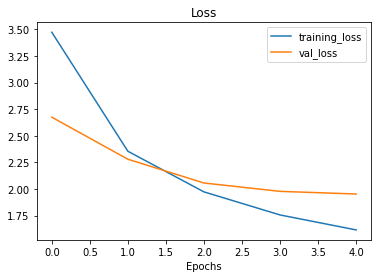

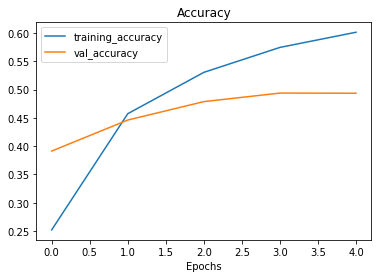

In [13]:
plot_loss_curves(history_0)

## Fine-tuning

In [14]:
# Unfreeze all of the layers in the base model
base_model.trainable = True
# Refreeze every layer except the last 5
for layer in base_model.layers[:-5]:
  layer.trainable = False

In [15]:
# Recompile the model with lower learning rate
model_0.compile(loss='categorical_crossentropy',
                optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                metrics=['accuracy'])

In [16]:
# What layers in the model are trainable
for layer in model_0.layers:
  print(layer.name, layer.trainable)

input_layer True
data_augmentation True
efficientnetb0 True
global_average_pooling_layer True
output_layer True


In [17]:
# Check which layers are trainable in the base model
for i, layer in enumerate(model_0.layers[2].layers):
  print(i, layer.name, layer.trainable)

0 input_1 False
1 rescaling False
2 normalization False
3 stem_conv_pad False
4 stem_conv False
5 stem_bn False
6 stem_activation False
7 block1a_dwconv False
8 block1a_bn False
9 block1a_activation False
10 block1a_se_squeeze False
11 block1a_se_reshape False
12 block1a_se_reduce False
13 block1a_se_expand False
14 block1a_se_excite False
15 block1a_project_conv False
16 block1a_project_bn False
17 block2a_expand_conv False
18 block2a_expand_bn False
19 block2a_expand_activation False
20 block2a_dwconv_pad False
21 block2a_dwconv False
22 block2a_bn False
23 block2a_activation False
24 block2a_se_squeeze False
25 block2a_se_reshape False
26 block2a_se_reduce False
27 block2a_se_expand False
28 block2a_se_excite False
29 block2a_project_conv False
30 block2a_project_bn False
31 block2b_expand_conv False
32 block2b_expand_bn False
33 block2b_expand_activation False
34 block2b_dwconv False
35 block2b_bn False
36 block2b_activation False
37 block2b_se_squeeze False
38 block2b_se_reshape F

In [18]:
# Fine-tunefor 5 more epochs
fine_tune_epochs = 10
history_1 = model_0.fit(train_data_all_10_percent,
                        epochs=fine_tune_epochs,
                        validation_data=test_data_all_10_percent,
                        validation_steps=int(0.15*len(test_data_all_10_percent)),
                        initial_epoch=history_0.epoch[-1])

Epoch 5/10
237/237 [==============================] - 52s 186ms/step - loss: 1.3471 - accuracy: 0.6531 - val_loss: 1.9450 - val_accuracy: 0.4971
Epoch 6/10
237/237 [==============================] - 41s 173ms/step - loss: 1.2364 - accuracy: 0.6700 - val_loss: 1.9378 - val_accuracy: 0.5008
Epoch 7/10
237/237 [==============================] - 41s 171ms/step - loss: 1.1551 - accuracy: 0.6911 - val_loss: 1.9422 - val_accuracy: 0.5024
Epoch 8/10
237/237 [==============================] - 40s 169ms/step - loss: 1.1024 - accuracy: 0.7053 - val_loss: 1.9477 - val_accuracy: 0.5024
Epoch 9/10
237/237 [==============================] - 40s 165ms/step - loss: 1.0217 - accuracy: 0.7290 - val_loss: 1.9464 - val_accuracy: 0.5034
Epoch 10/10
237/237 [==============================] - 39s 164ms/step - loss: 0.9616 - accuracy: 0.7439 - val_loss: 1.9618 - val_accuracy: 0.5005


In [19]:
fine_tuning_results = model_0.evaluate(test_data_all_10_percent)
fine_tuning_results

790/790 [==============================] - 79s 100ms/step - loss: 1.6398 - accuracy: 0.5697


[1.6397535800933838, 0.5697029829025269]

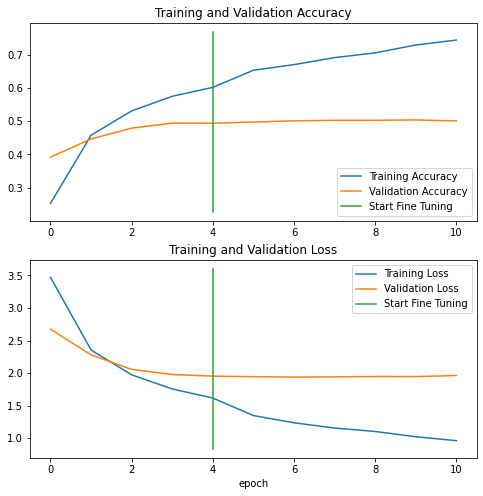

In [20]:
compare_historys(history_0, history_1)

## Saving and loading our model

In [21]:
# Save fine-tuned model
model_0.save("drive/MyDrive/tensorflow_course/101_food_model")

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: drive/MyDrive/tensorflow_course/101_food_model/assets


In [22]:
# Load and evaluate saved model
loaded_model = tf.keras.models.load_model("drive/MyDrive/tensorflow_course/101_food_model")

In [23]:
# Evaluate loaded model and compare performance to pre-saved model
loaded_model_results = loaded_model.evaluate(test_data_all_10_percent)
loaded_model_results

790/790 [==============================] - 82s 102ms/step - loss: 1.6398 - accuracy: 0.5697


[1.6397535800933838, 0.5697029829025269]

In [24]:
fine_tuning_results

[1.6397535800933838, 0.5697029829025269]

## Evaluating the performance of the build model across all different classes
Make predictions, visualize them and then later find out which predictions were the "most" wrong.

In [25]:
import tensorflow as tf
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/06_101_food_class_10_percent_saved_big_dog_model.zip

--2021-08-09 01:26:31--  https://storage.googleapis.com/ztm_tf_course/food_vision/06_101_food_class_10_percent_saved_big_dog_model.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.5.128, 74.125.206.128, 64.233.184.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.5.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 46760742 (45M) [application/zip]
Saving to: ‘06_101_food_class_10_percent_saved_big_dog_model.zip’

06_101_food_class_1 100%[===================>]  44.59M  33.3MB/s    in 1.3s    

2021-08-09 01:26:34 (33.3 MB/s) - ‘06_101_food_class_10_percent_saved_big_dog_model.zip’ saved [46760742/46760742]



In [26]:
unzip_data("/content/06_101_food_class_10_percent_saved_big_dog_model.zip")

In [27]:
# Load in saved model
model = tf.keras.models.load_model('/content/06_101_food_class_10_percent_saved_big_dog_model')

In [28]:
results_downloaded_model = loaded_model.evaluate(test_data_all_10_percent)
results_downloaded_model

790/790 [==============================] - 83s 105ms/step - loss: 1.6398 - accuracy: 0.5697


[1.6397535800933838, 0.5697029829025269]

## Making predictions with the trained model

In [29]:
# Make predictions
preds_probs = loaded_model.predict(test_data_all_10_percent, verbose=1)

790/790 [==============================] - 69s 85ms/step


In [30]:
preds_probs.shape

(25250, 101)

In [31]:
# See what the first 10 predictions look like
preds_probs[:10]

array([[2.35730484e-01, 2.39498040e-04, 1.05643496e-01, ...,
        1.14983581e-04, 2.07222742e-03, 1.23212762e-01],
       [8.75594616e-01, 8.65618745e-07, 2.64085457e-03, ...,
        5.01721678e-03, 6.56748171e-07, 7.55597830e-06],
       [1.35488957e-01, 3.59328534e-03, 1.30943842e-02, ...,
        3.01763794e-04, 1.91298756e-03, 4.20428300e-03],
       ...,
       [2.40594819e-01, 6.52605013e-05, 1.60955195e-03, ...,
        5.91749698e-02, 3.32399854e-04, 9.83766513e-05],
       [8.05140287e-02, 1.76657678e-03, 9.43364576e-02, ...,
        4.81869938e-04, 3.87345557e-04, 5.18361689e-04],
       [3.70394468e-01, 4.75962679e-06, 1.98442955e-03, ...,
        1.07985707e-02, 1.04105047e-05, 4.12016921e-03]], dtype=float32)

In [32]:
max(preds_probs[0])

0.23573048

In [33]:
# Get the pred classes of each label
pred_classes = preds_probs.argmax(axis=1)
pred_classes[:10]

array([ 0,  0, 14,  8, 29, 78, 29, 46,  9,  0])

In [34]:
len(pred_classes)

25250

In [35]:
test_data = test_data_all_10_percent
test_data

<BatchDataset shapes: ((None, 224, 224, 3), (None, 101)), types: (tf.float32, tf.float32)>

In [36]:
y_labels = []
for images, labels in test_data.unbatch():
  y_labels.append(labels.numpy().argmax())
y_labels[:10]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [37]:
import numpy as np
y_labels_np = np.array(y_labels)
y_labels_np.shape

(25250,)

In [38]:
min(y_labels)

0

In [39]:
len(y_labels)

25250

## Evaluating model's predictions
One way to check that our model's predictions array is in the same order as our test labels array is to find the accuracy score.

In [40]:
results_downloaded_model

[1.6397535800933838, 0.5697029829025269]

In [41]:
# Try scikit-learn's accuracy score function and see what it come up with
from sklearn.metrics import accuracy_score
sklearn_accuracy = accuracy_score(y_true=y_labels,
                                  y_pred=pred_classes)
sklearn_accuracy

0.5697029702970297

In [42]:
import numpy as np
np.isclose(results_downloaded_model[1], sklearn_accuracy)

True

## Make a confusion matrix

In [43]:
# Get a list of class name
class_names = test_data.class_names
class_names

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito',
 'bruschetta',
 'caesar_salad',
 'cannoli',
 'caprese_salad',
 'carrot_cake',
 'ceviche',
 'cheese_plate',
 'cheesecake',
 'chicken_curry',
 'chicken_quesadilla',
 'chicken_wings',
 'chocolate_cake',
 'chocolate_mousse',
 'churros',
 'clam_chowder',
 'club_sandwich',
 'crab_cakes',
 'creme_brulee',
 'croque_madame',
 'cup_cakes',
 'deviled_eggs',
 'donuts',
 'dumplings',
 'edamame',
 'eggs_benedict',
 'escargots',
 'falafel',
 'filet_mignon',
 'fish_and_chips',
 'foie_gras',
 'french_fries',
 'french_onion_soup',
 'french_toast',
 'fried_calamari',
 'fried_rice',
 'frozen_yogurt',
 'garlic_bread',
 'gnocchi',
 'greek_salad',
 'grilled_cheese_sandwich',
 'grilled_salmon',
 'guacamole',
 'gyoza',
 'hamburger',
 'hot_and_sour_soup',
 'hot_dog',
 'huevos_rancheros',
 'hummus',
 'ice_cream',
 'lasagna',
 'lobster_bisque',
 'lobster

In [44]:
import itertools
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix
# Ensure the x_labels print vertically
def make_confusion_matrix_2(y_true, y_pred, classes=None, figsize=(10, 10), text_size=15, norm=False, savefig=False): 
  """Makes a labelled confusion matrix comparing predictions and ground truth labels.

  If classes is passed, confusion matrix will be labelled, if not, integer class values
  will be used.

  Args:
    y_true: Array of truth labels (must be same shape as y_pred).
    y_pred: Array of predicted labels (must be same shape as y_true).
    classes: Array of class labels (e.g. string form). If `None`, integer labels are used.
    figsize: Size of output figure (default=(10, 10)).
    text_size: Size of output figure text (default=15).
    norm: normalize values or not (default=False).
    savefig: save confusion matrix to file (default=False).
  
  Returns:
    A labelled confusion matrix plot comparing y_true and y_pred.

  Example usage:
    make_confusion_matrix(y_true=test_labels, # ground truth test labels
                          y_pred=y_preds, # predicted labels
                          classes=class_names, # array of class label names
                          figsize=(15, 15),
                          text_size=10)
  """  
  # Create the confustion matrix
  cm = confusion_matrix(y_true, y_pred)
  cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis] # normalize it
  n_classes = cm.shape[0] # find the number of classes we're dealing with

  # Plot the figure and make it pretty
  fig, ax = plt.subplots(figsize=figsize)
  cax = ax.matshow(cm, cmap=plt.cm.Blues) # colors will represent how 'correct' a class is, darker == better
  fig.colorbar(cax)

  # Are there a list of classes?
  if classes:
    labels = classes
  else:
    labels = np.arange(cm.shape[0])
  
  # Label the axes
  ax.set(title="Confusion Matrix",
         xlabel="Predicted label",
         ylabel="True label",
         xticks=np.arange(n_classes), # create enough axis slots for each class
         yticks=np.arange(n_classes), 
         xticklabels=labels, # axes will labeled with class names (if they exist) or ints
         yticklabels=labels)
  
  # Make x-axis labels appear on bottom
  ax.xaxis.set_label_position("bottom")
  ax.xaxis.tick_bottom()

  # Changed (plot x-labels vertically)
  plt.xticks(rotation=70, fontsize=text_size)
  plt.yticks(fontsize=text_size)

  # Set the threshold for different colors
  threshold = (cm.max() + cm.min()) / 2.

  # Plot the text on each cell
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    if norm:
      plt.text(j, i, f"{cm[i, j]} ({cm_norm[i, j]*100:.1f}%)",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)
    else:
      plt.text(j, i, f"{cm[i, j]}",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)

  # Save the figure to the current working directory
  if savefig:
    fig.savefig("confusion_matrix.png")
  

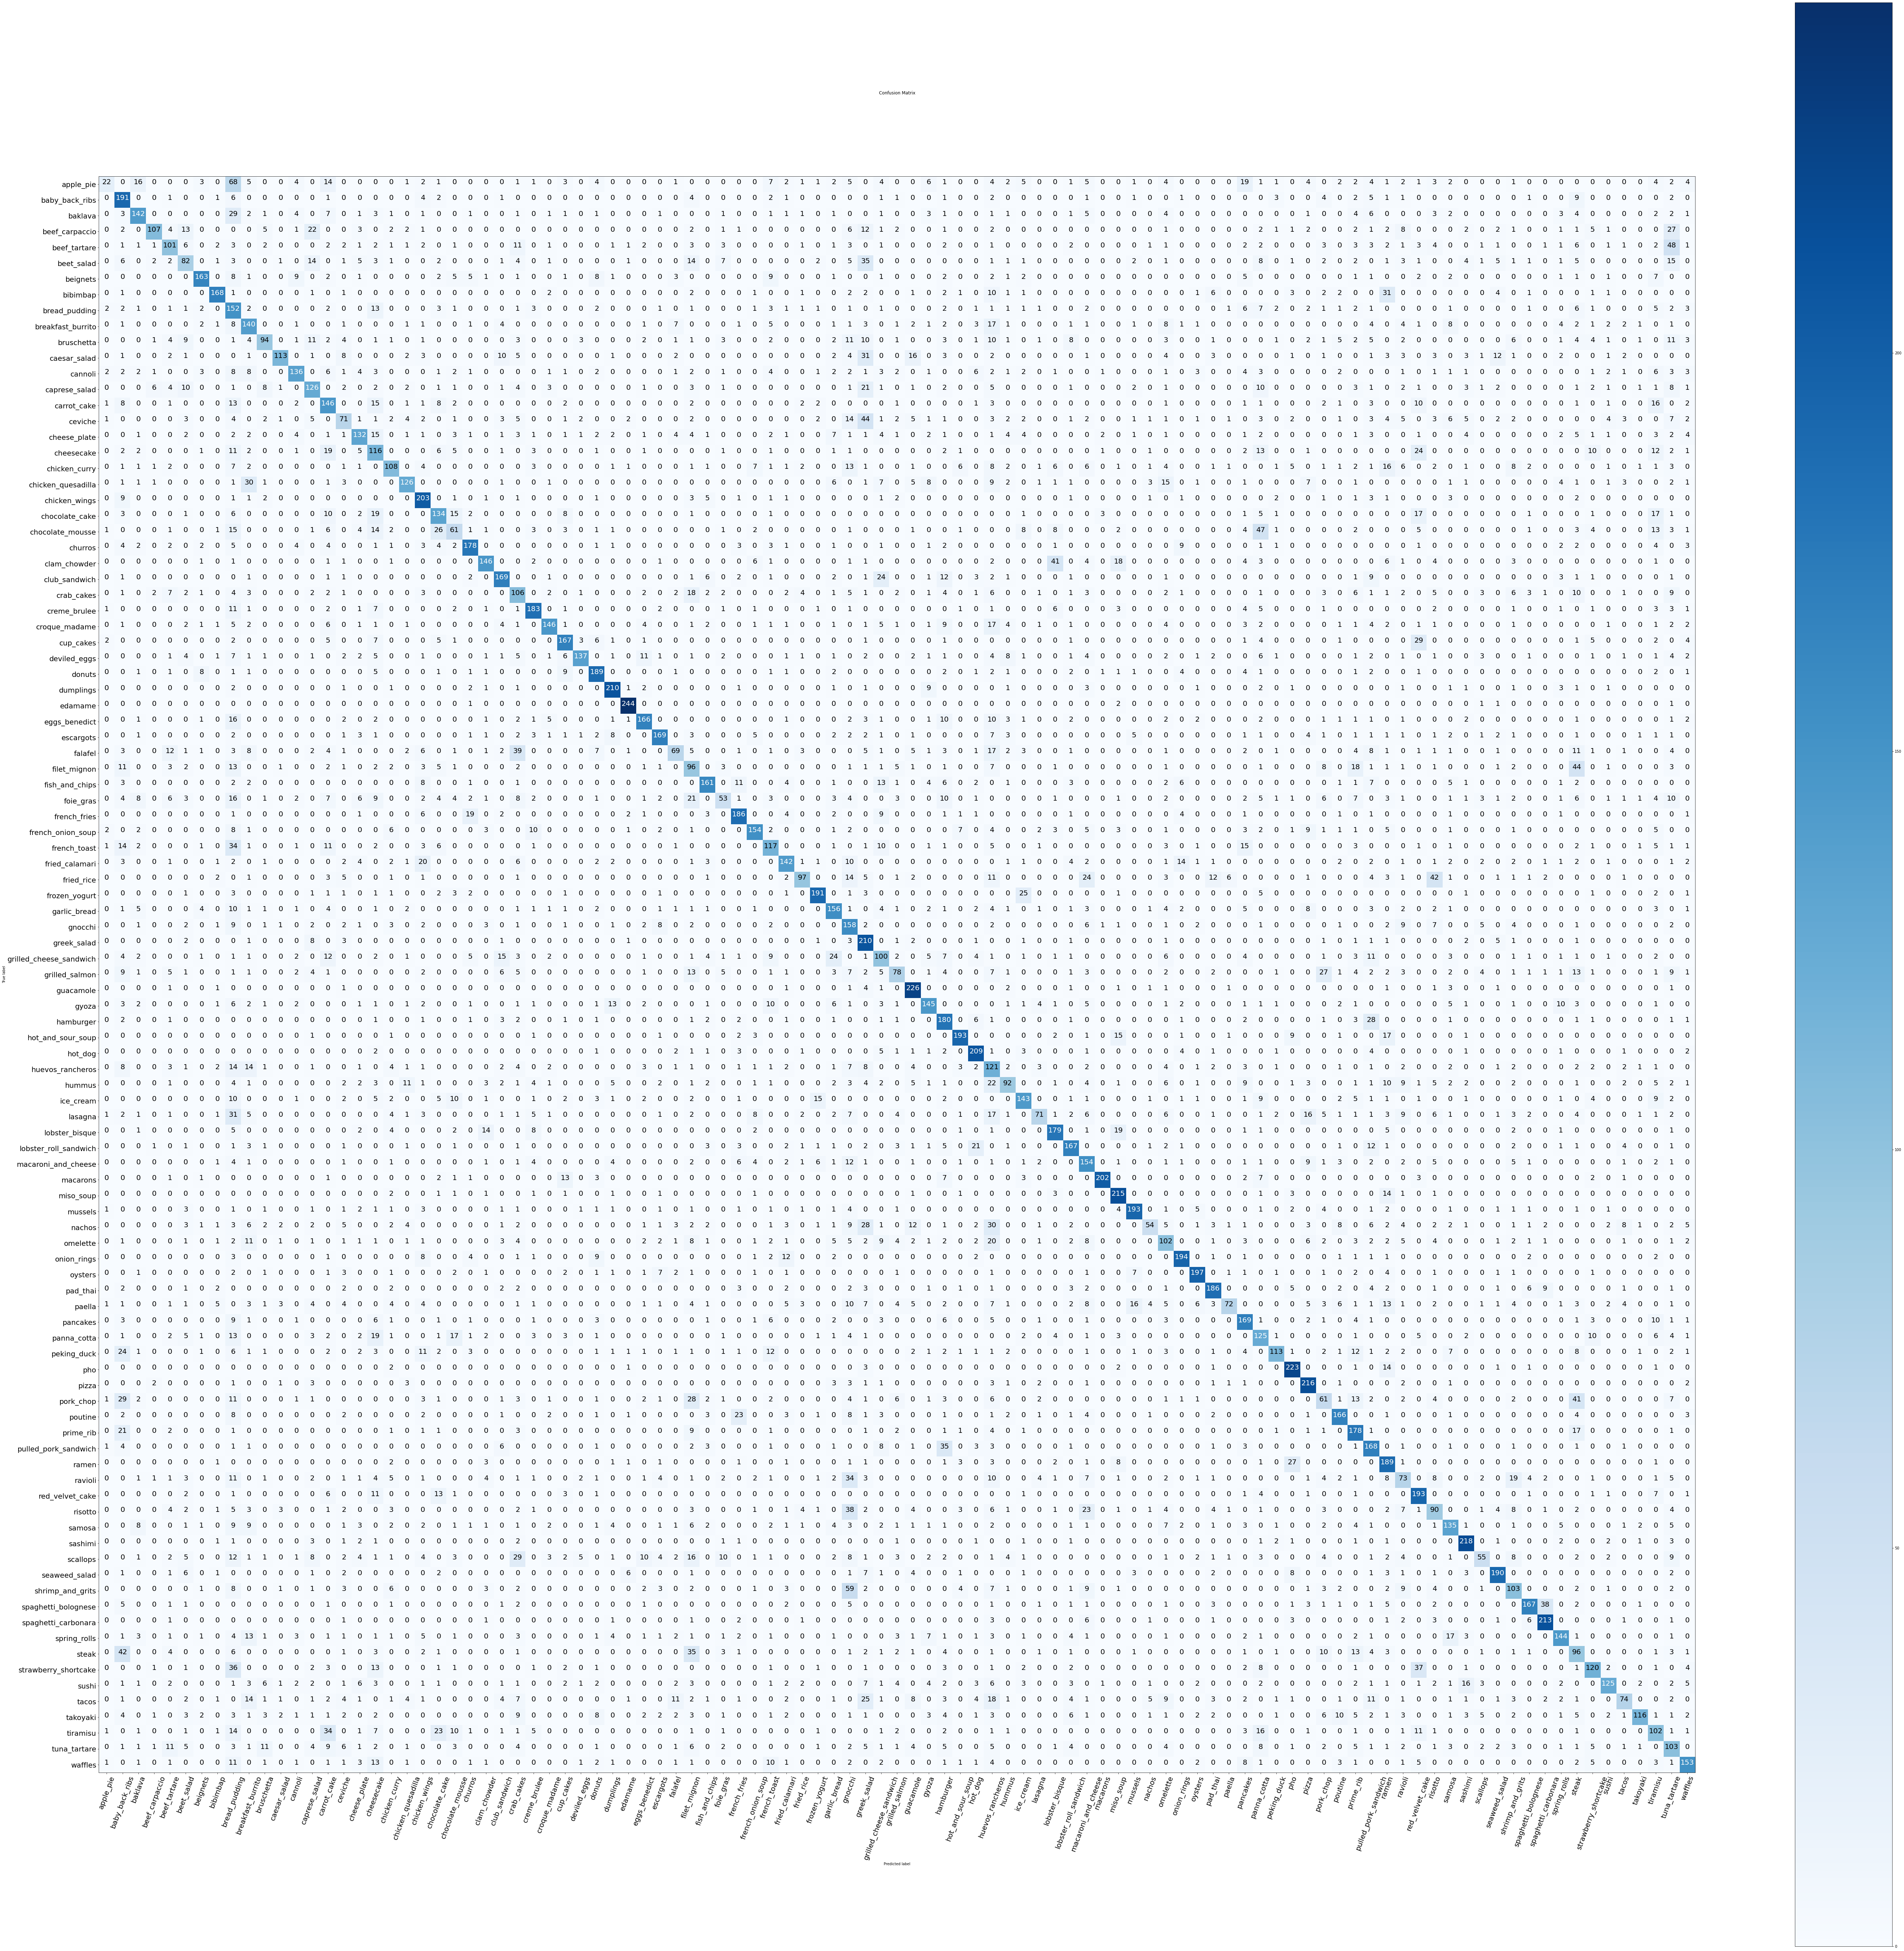

In [45]:
make_confusion_matrix_2(y_true=y_labels,
                      y_pred=pred_classes,
                      classes=class_names,
                      figsize=(100, 100),
                      text_size=20,
                      savefig=True)

## Classification report

In [46]:
from sklearn.metrics import classification_report
print(classification_report(y_true=y_labels,
                            y_pred=pred_classes))

              precision    recall  f1-score   support

           0       0.52      0.09      0.15       250
           1       0.42      0.76      0.54       250
           2       0.65      0.57      0.61       250
           3       0.83      0.43      0.56       250
           4       0.50      0.40      0.45       250
           5       0.42      0.33      0.37       250
           6       0.80      0.65      0.72       250
           7       0.84      0.67      0.75       250
           8       0.20      0.61      0.30       250
           9       0.44      0.56      0.49       250
          10       0.61      0.38      0.47       250
          11       0.85      0.45      0.59       250
          12       0.72      0.54      0.62       250
          13       0.52      0.50      0.51       250
          14       0.42      0.58      0.49       250
          15       0.41      0.28      0.33       250
          16       0.62      0.53      0.57       250
          17       0.33    

In [47]:
pred_classes.shape

(25250,)

In [48]:
np.array(y_labels).shape

(25250,)

In [49]:
 # Get a dictionary of classification reports
 classification_report_dict = classification_report(y_labels, pred_classes, output_dict=True)
 classification_report_dict

{'0': {'f1-score': 0.1506849315068493,
  'precision': 0.5238095238095238,
  'recall': 0.088,
  'support': 250},
 '1': {'f1-score': 0.5441595441595443,
  'precision': 0.4225663716814159,
  'recall': 0.764,
  'support': 250},
 '10': {'f1-score': 0.4653465346534653,
  'precision': 0.6103896103896104,
  'recall': 0.376,
  'support': 250},
 '100': {'f1-score': 0.6309278350515464,
  'precision': 0.6510638297872341,
  'recall': 0.612,
  'support': 250},
 '11': {'f1-score': 0.5900783289817233,
  'precision': 0.849624060150376,
  'recall': 0.452,
  'support': 250},
 '12': {'f1-score': 0.6210045662100457,
  'precision': 0.723404255319149,
  'recall': 0.544,
  'support': 250},
 '13': {'f1-score': 0.511156186612576,
  'precision': 0.5185185185185185,
  'recall': 0.504,
  'support': 250},
 '14': {'f1-score': 0.4858569051580699,
  'precision': 0.41595441595441596,
  'recall': 0.584,
  'support': 250},
 '15': {'f1-score': 0.3349056603773585,
  'precision': 0.40804597701149425,
  'recall': 0.284,
  's

Plot all of classes' F1-scores

In [50]:
classification_report_dict["99"]["f1-score"]

0.33279483037156704

In [51]:
# Create empty dictionaries
class_f1_scores = {}
# Loop through classification
for k, v in classification_report_dict.items():
  if k == 'accuracy': # stop once we get to accuracy
    break
  else:
    # Add class names and f1-scores to new dict
    class_f1_scores[class_names[int(k)]] = v["f1-score"]

In [52]:
class_f1_scores

{'apple_pie': 0.1506849315068493,
 'baby_back_ribs': 0.5441595441595443,
 'baklava': 0.6068376068376068,
 'beef_carpaccio': 0.5646437994722955,
 'beef_tartare': 0.445916114790287,
 'beet_salad': 0.367713004484305,
 'beignets': 0.7180616740088106,
 'bibimbap': 0.7450110864745012,
 'bread_pudding': 0.2986247544204322,
 'breakfast_burrito': 0.4912280701754386,
 'bruschetta': 0.4653465346534653,
 'caesar_salad': 0.5900783289817233,
 'cannoli': 0.6210045662100457,
 'caprese_salad': 0.511156186612576,
 'carrot_cake': 0.4858569051580699,
 'ceviche': 0.3349056603773585,
 'cheese_plate': 0.5689655172413793,
 'cheesecake': 0.38283828382838286,
 'chicken_curry': 0.4897959183673469,
 'chicken_quesadilla': 0.5901639344262295,
 'chicken_wings': 0.684654300168634,
 'chocolate_cake': 0.5173745173745173,
 'chocolate_mousse': 0.2932692307692308,
 'churros': 0.725050916496945,
 'clam_chowder': 0.6503340757238307,
 'club_sandwich': 0.6719681908548708,
 'crab_cakes': 0.37323943661971826,
 'creme_brulee': 0

In [53]:
# Turn f1-scores into data frames
import pandas as pd
f1_scores = pd.DataFrame({"class_names": list(class_f1_scores.keys()),
                          "f1-score": list(class_f1_scores.values())}).sort_values("f1-score", ascending=False)

In [54]:
f1_scores

class_names  f1-score
33              edamame  0.943907
63             macarons  0.874459
91  spaghetti_carbonara  0.812977
86              sashimi  0.811918
69              oysters  0.809035
..                  ...       ...
8         bread_pudding  0.298625
39            foie_gras  0.294444
22     chocolate_mousse  0.293269
77            pork_chop  0.280460
0             apple_pie  0.150685

[101 rows x 2 columns]

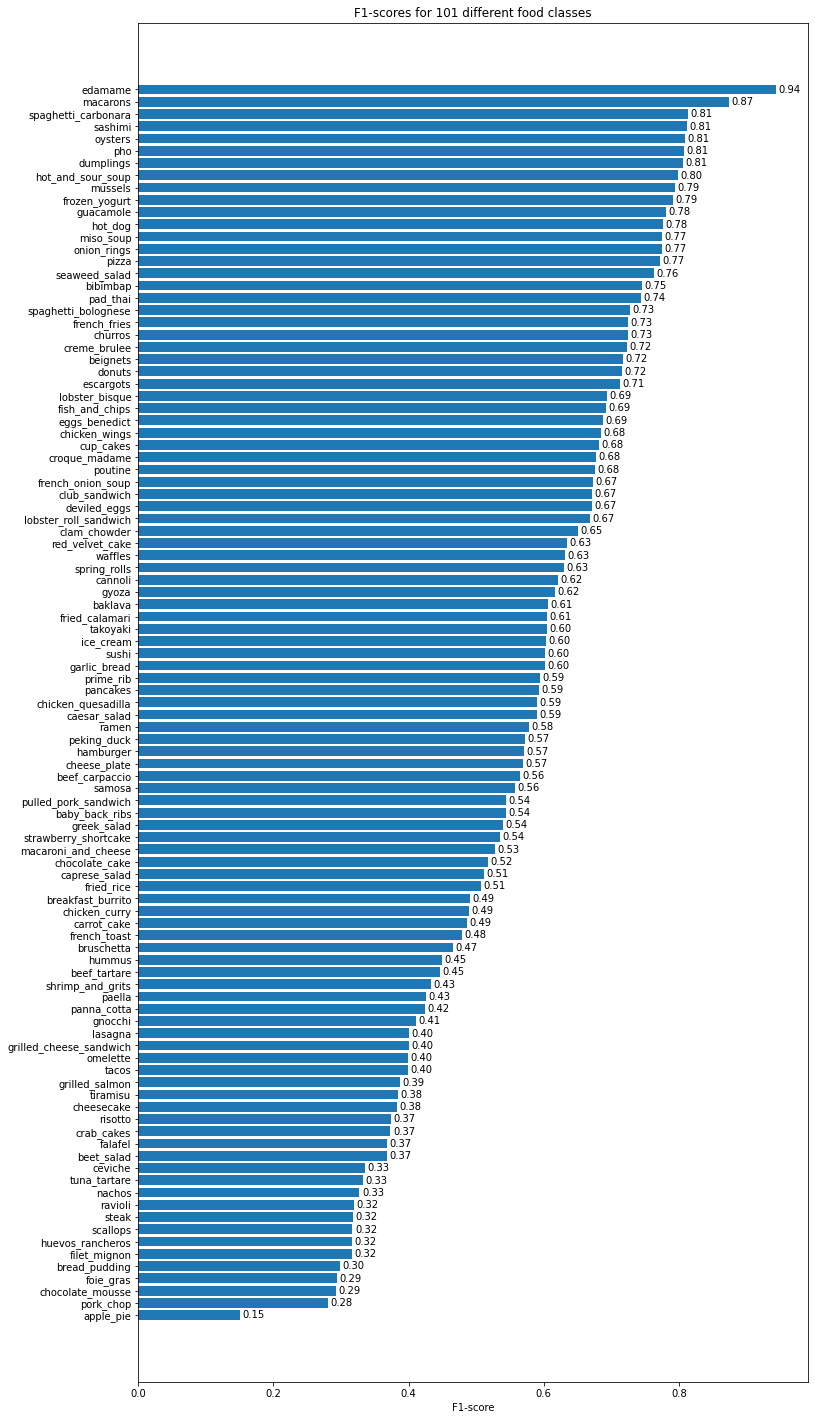

In [55]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(12, 25))
scores = ax.barh(range(len(f1_scores)), f1_scores["f1-score"].values) # get f1-score values
ax.set_yticks(range(len(f1_scores)))
ax.set_yticklabels(f1_scores['class_names'])
ax.set_xlabel("F1-score")
ax.set_title("F1-scores for 101 different food classes")
ax.invert_yaxis(); # Reverse the order of the plot
def autolabel(rects):
    """
    Attach a text label above each bar displaying its height
    """
    for rect in rects:
        width = rect.get_width()
        ax.text(width+0.02, rect.get_y() + rect.get_height(),
                f"{width:.2f}",
                ha='center', va='bottom')

autolabel(scores)

## Visualizing predictions on test images

* Load and preprocess images
* Read in a target image filepath using tf.io.read_file()
* Turn the image into a tensor using tf.io.decode_image()
* Resize the image with tf.image.resize()
* Normalize if necessary

In [56]:
def load_and_prep_image(filename, img_shape=224, scale=True):
  '''
  Reads in an image from filename, turns it into a tensor and reshapes into
  specified shape

  Args:
    filename(str): path to target image
    image_shape(int): height/width dimension of target image size
    scale (bool): normalize or not
  
  Returns:
    Image tensor of shape
  '''
  # Read in the image
  img = tf.io.read_file(filename)

  # Decode image into tensor
  img = tf.io.decode_image(img, channels=3)

  # Resize the image
  img = tf.image.resize(img, size=[img_shape, img_shape])

  # Scale? Yes/no
  if scale:
    # rescale the image (get all values between 0 and 1)
    return img/255.
  
  else:
    return img

Write some code to:
1. Load a few random images from the test dataset
2. Make predictions on the loaded images
3. Plot the original image(s) along with the model's predictions, prediction probability and truth label

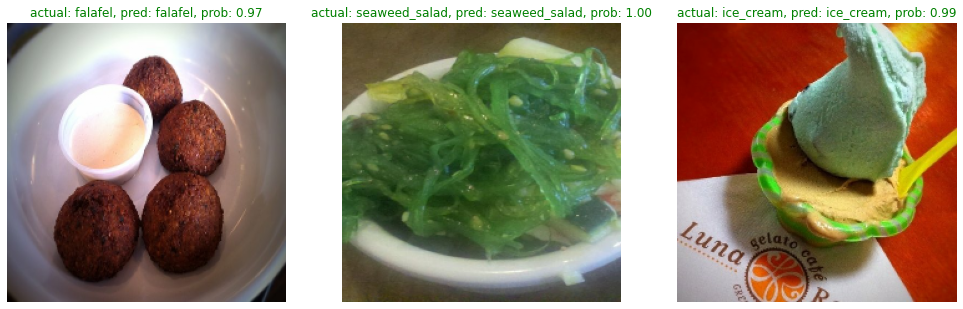

In [57]:
# Make preds on a series of random images
import os
import random
plt.figure(figsize=(17, 10))
for i in range(3):
  # choose a random images from random classes
  class_name = random.choice(class_names)
  filename = random.choice(os.listdir(test_dir + '/' + class_name))
  filepath = test_dir + class_name + "/" + filename
  # Load the image and make predictions
  img = load_and_prep_image(filepath, scale=False)
  img_expanded = tf.expand_dims(img, axis=0)
  pred_prob = model.predict(img_expanded) # get prediction probabilities array
  pred_class = class_names[pred_prob.argmax()] # get highest prediction probability index and match it with class_names list 
  plt.subplot(1, 3, i+1)
  plt.imshow(img/255.)

  if class_name == pred_class: # if predicted class matches truth class, make text greens
    title_color = 'g'
  else:
    title_color = 'r'
  plt.title(f"actual: {class_name}, pred: {pred_class}, prob: {pred_prob.max():.2f}", c=title_color)
  plt.axis(False);

## Finding the most wrong predictions

1. Get all of the image file paths in the test dataset using `list_files()` method
2. Create a pandas DataFrame of the image filepaths, ground truth labels, predicted classes (from our model), max prediction probabilities, prediction class names, ground truth class names.  
3. Use DataFrame to find all the wrong predictions (where the ground truth label doesn't match the prediction).
4. Sort the DataFrame based on wrong predictions (have the highest prediction probability predictions at the top).
5. Visualize the images with the highest prediction probabilities but have the wrong prediction.

In [58]:
# 1. Get all of the image file paths in the test dataset
filepaths = []
for filepath in test_data.list_files("/content/101_food_classes_10_percent/test/*/*.jpg",
                                     shuffle=False):
  filepaths.append(filepath.numpy())
filepaths[:10]

[b'/content/101_food_classes_10_percent/test/apple_pie/1011328.jpg',
 b'/content/101_food_classes_10_percent/test/apple_pie/101251.jpg',
 b'/content/101_food_classes_10_percent/test/apple_pie/1034399.jpg',
 b'/content/101_food_classes_10_percent/test/apple_pie/103801.jpg',
 b'/content/101_food_classes_10_percent/test/apple_pie/1038694.jpg',
 b'/content/101_food_classes_10_percent/test/apple_pie/1047447.jpg',
 b'/content/101_food_classes_10_percent/test/apple_pie/1068632.jpg',
 b'/content/101_food_classes_10_percent/test/apple_pie/110043.jpg',
 b'/content/101_food_classes_10_percent/test/apple_pie/1106961.jpg',
 b'/content/101_food_classes_10_percent/test/apple_pie/1113017.jpg']

In [60]:
# 2. Create a DataFrame of different parameters for each of our test images
import pandas as pd
pred_df = pd.DataFrame({"img_path": filepaths,
                        "y_true": y_labels,
                        "y_pred": pred_classes,
                        "pred_conf": preds_probs.max(axis=1),
                        "y_true_classname": [class_names[i] for i in y_labels],
                        "y_pred_classname": [class_names[i] for i in pred_classes]})
pred_df

img_path  ...  y_pred_classname
0      b'/content/101_food_classes_10_percent/test/ap...  ...         apple_pie
1      b'/content/101_food_classes_10_percent/test/ap...  ...         apple_pie
2      b'/content/101_food_classes_10_percent/test/ap...  ...       carrot_cake
3      b'/content/101_food_classes_10_percent/test/ap...  ...     bread_pudding
4      b'/content/101_food_classes_10_percent/test/ap...  ...         cup_cakes
...                                                  ...  ...               ...
25245  b'/content/101_food_classes_10_percent/test/wa...  ...           waffles
25246  b'/content/101_food_classes_10_percent/test/wa...  ...      cheese_plate
25247  b'/content/101_food_classes_10_percent/test/wa...  ...           waffles
25248  b'/content/101_food_classes_10_percent/test/wa...  ...             steak
25249  b'/content/101_food_classes_10_percent/test/wa...  ...           waffles

[25250 rows x 6 columns]

In [61]:
# 3. Find out in out DataFrame which predictions are wrong
pred_df["pred_correct"] = pred_df["y_true"] == pred_df["y_pred"]
pred_df.head()

img_path  ...  pred_correct
0  b'/content/101_food_classes_10_percent/test/ap...  ...          True
1  b'/content/101_food_classes_10_percent/test/ap...  ...          True
2  b'/content/101_food_classes_10_percent/test/ap...  ...         False
3  b'/content/101_food_classes_10_percent/test/ap...  ...         False
4  b'/content/101_food_classes_10_percent/test/ap...  ...         False

[5 rows x 7 columns]

In [63]:
# 4. Sort DataFrame to have most wrong predictions at the top
top_100_wrong = pred_df[pred_df["pred_correct"] == False].sort_values("pred_conf", ascending=False)[:100]
top_100_wrong

img_path  ...  pred_correct
23631  b'/content/101_food_classes_10_percent/test/st...  ...         False
22203  b'/content/101_food_classes_10_percent/test/se...  ...         False
23797  b'/content/101_food_classes_10_percent/test/su...  ...         False
21810  b'/content/101_food_classes_10_percent/test/sc...  ...         False
10847  b'/content/101_food_classes_10_percent/test/fr...  ...         False
...                                                  ...  ...           ...
7477   b'/content/101_food_classes_10_percent/test/cu...  ...         False
23283  b'/content/101_food_classes_10_percent/test/st...  ...         False
14651  b'/content/101_food_classes_10_percent/test/ic...  ...         False
21815  b'/content/101_food_classes_10_percent/test/sc...  ...         False
15177  b'/content/101_food_classes_10_percent/test/lo...  ...         False

[100 rows x 7 columns]

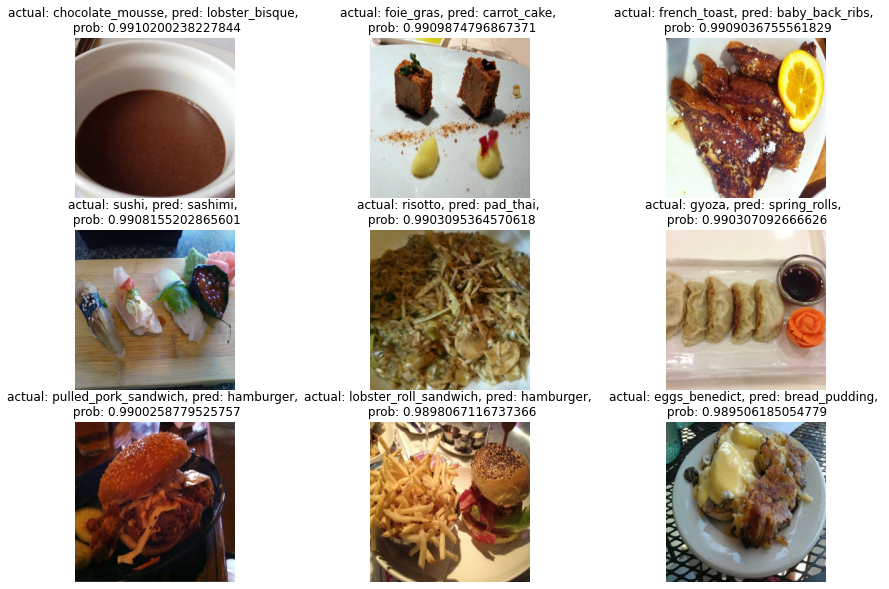

In [68]:
# 5. Visualize the test data sampes which have the wrong prediction but highest prediction probability
images_to_view = 9
start_index = 10
plt.figure(figsize=(15, 10))
for i, row in enumerate(top_100_wrong[start_index:start_index+images_to_view].itertuples()):
  plt.subplot(3, 3, i+1)
  img = load_and_prep_image(row[1], scale=False)
  _, _, _, _, pred_prob, y_true_classname, y_pred_classname, _ = row # Only interested in certain parameters
  plt.imshow(img/255.)
  plt.title(f"actual: {y_true_classname}, pred: {y_pred_classname}, \n prob: {pred_prob}")
  plt.axis(False)

## Test out the big dog model on our own custom images

In [69]:
# Get custom images
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/custom_food_images.zip
unzip_data("custom_food_images.zip")

--2021-08-09 02:20:09--  https://storage.googleapis.com/ztm_tf_course/food_vision/custom_food_images.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.13.128, 142.250.110.128, 142.251.5.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.13.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13192985 (13M) [application/zip]
Saving to: ‘custom_food_images.zip’

custom_food_images. 100%[===================>]  12.58M  42.3MB/s    in 0.3s    

2021-08-09 02:20:10 (42.3 MB/s) - ‘custom_food_images.zip’ saved [13192985/13192985]



In [71]:
# Get the custom food images filepaths
custom_food_images = ["custom_food_images/" + img_path for img_path in os.listdir("custom_food_images")]
custom_food_images

['custom_food_images/chicken_wings.jpeg',
 'custom_food_images/steak.jpeg',
 'custom_food_images/sushi.jpeg',
 'custom_food_images/pizza-dad.jpeg',
 'custom_food_images/hamburger.jpeg',
 'custom_food_images/ramen.jpeg']

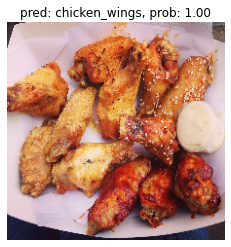

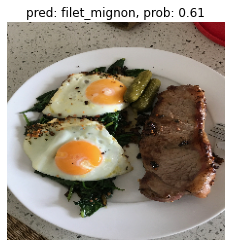

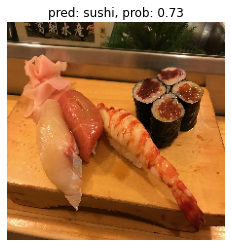

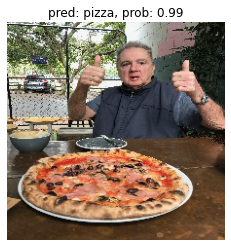

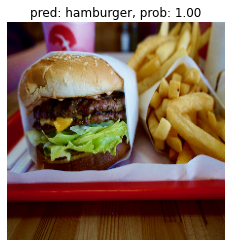

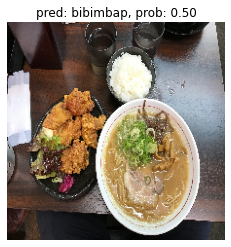

In [73]:
# make predictions on and plot custom food images
for img in custom_food_images:
  img = load_and_prep_image(img, scale=False)
  pred_prob = model.predict(tf.expand_dims(img, axis=0))
  pred_class = class_names[pred_prob.argmax()] # get te index with the highest prediction probability
  # Plot the appropriate information
  plt.figure()
  plt.imshow(img/255.)
  plt.title(f"pred: {pred_class}, prob: {pred_prob.max():.2f}")
  plt.axis(False)